# Solving mixed integer programs with Julia/JuMP

<i>Copyright 2016, Pedro Belin Castellucci,

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.</i>


In this Notebook, we will explore some basics of the JuMP modeling language. Although it is a modeling language, it enables the usage of different solvers. By ways of an example, we will use [Clp](https://projects.coin-or.org/Clp)
-- a complete list of supported solvers and JuMP documentation can be found at this [link](https://jump.readthedocs.io/en/latest/). Also, JuMP support linear programming, mixed-integer programming, second-order conic programming, semidefinite programming, and nonlinear programming, but we will focus on linear and integer programming here.

The first step is to install JuMP.

In [1]:
Pkg.add("JuMP")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of JuMP
INFO: Use `Pkg.update()` to get the latest versions of your packages


We can also install Clp in the same way.

In [2]:
Pkg.add("Clp");

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Clp
INFO: Use `Pkg.update()` to get the latest versions of your packages


To get a feeling of JuMP basic functions we will implement the following model:

$Max\ x + y$

subject to:

$2x + 3y \leq 10,$

$3x + 2y \leq 10.$

We begin by creating a Model object.

In [3]:
using JuMP  # Tell that we are using the JuMP library.
using Clp   # Tell that we are using the Clp solver.

m = Model()  # Creating the Model object.

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is default solver

The second step is to define the variables. Their are associated with the model and can be created using the <i>@variable</i> macro.

In [4]:
@variable(m, x)
@variable(m, y)

y

Then, the objective function.

In [5]:
@objective(m, Max, x + y)

x + y

Finally, the constraints.

In [6]:
@constraint(m, 2x + 3y <= 10)
@constraint(m, 3x + 2y <= 10)

m  # Just to diplay our model

Maximization problem with:
 * 2 linear constraints
 * 2 variables
Solver is default solver

Now that we have completely defined our model, we may want to solve it.

In [7]:
solve(m)

:Optimal

The solve function returns the status of the solving procedure. We can query for the solution and variable values using <i>getobjectivevalue</i> and <i>getvalue</i> functions.

In [8]:
println("Objective function = ", getobjectivevalue(m))

println("x = ", getvalue(x))
println("y = ", getvalue(y))

Objective function = 4.0
x = 2.0
y = 2.0


## Exercise

Implement and solve the following model:

$Min\ 2x - 3y + z$

subject to:

$x - y - z = 10,$

$3x - 4y + 4z \geq 25,$

$x, y, z \geq 0.$

## The least absolute method

In this example, let us assume we have some experimental data and want to fit a linear model to it. Perhaps, the most famous method to accomplish this is the Least Square Method, which finds the linear model that minimizes the squared error, i. e. the distance from data points to the "model points". Instead of minimizing the squared error, we will minimize the absolute error. More formally, we have experimental points $(x_i, y_i)$, $i = 1, \ldots, n$ and we want the parameters $(a, b)$ of a function $f(x) = ax + b$ such that:

$$\sum_{i=1}^n |f(x_i) - y_i|$$

is minimized. We can formulate a linear programming model of the problem using $a$, $b$ and $epsilon$ as decision variables:

$\displaystyle Min\ \sum_{i=1}^n\epsilon_i$,

subject to:

$\displaystyle y_i - a x_i - b \leq \epsilon_i, \quad i=1, \ldots, n$,

$\displaystyle - (y_i - a x_i - b) \leq \epsilon_i, \quad i=1, \ldots, n$ .

To test it, let us generate some data.

In [9]:
n = 10  # We will use 10 points.

points = Array{Float64, Float64}[]
points = zeros(0, 2)

for i=1:n
    
    # They are generated around the curve f(x) = x.
    xRand = rand()*3 - 3
    yRand = rand()*3 - 3

    x, y = i + xRand, i + yRand
    points = [points; x y]
end

points

10×2 Array{Float64,2}:
  0.740336  0.873669
 -0.191029  0.923925
  1.56304   2.30193 
  1.00935   1.91344 
  2.02678   4.74981 
  3.18444   4.93146 
  6.25287   4.94282 
  7.5942    7.4043  
  7.90294   8.4983  
  9.01165   7.32622 

To get a sense of the data, let us scatter plot it. For that, we are going to use the [Plots library](https://juliaplots.github.io).

In [10]:
Pkg.add("Plots")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Plots
INFO: Use `Pkg.update()` to get the latest versions of your packages


And then, we do a scatter plot of the points.


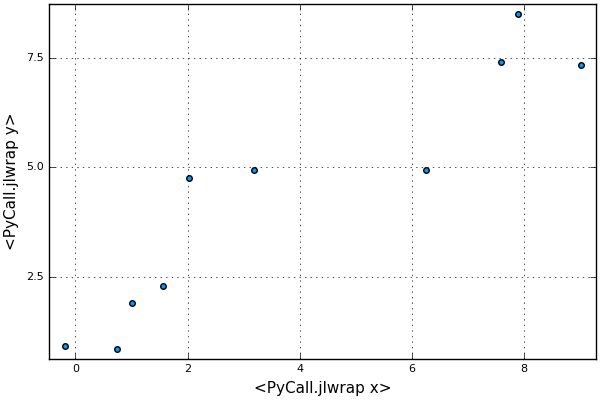

/home/pedro/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [11]:
using Plots

plot(points[:, 1], points[:, 2], t=[:scatter], label="", xlabel='x', ylabel='y')

Now, we implement the model presented earlier. Note how we used the function <i>sum</i>.

In [12]:
using JuMP

m = Model()  # Creating the model object.

# Defining the variables:
@variable(m, err[1:n])  # error (epsilon).
@variable(m, a)  # angular coefficient.
@variable(m, b)  # linear coefficient.

@objective(m, Min, sum(err[i] for i in 1:n))

for i in 1:n
    @constraint(m, points[i, 2] - a*points[i, 1] - b <= err[i])
    @constraint(m, -(points[i, 2] - a*points[i, 1] - b) <= err[i])
end

m

Minimization problem with:
 * 20 linear constraints
 * 12 variables
Solver is default solver

We want to solve the model and get the values of $a$ and $b$.

In [13]:
println("We have obtained an $(solve(m)) solution.")
println("a = $(getvalue(a))")
println("b = $(getvalue(b))")

We have obtained an Optimal solution.
a = 0.8338631274067264
b = 1.0717766223434346


Let us plot the solution to see the result.


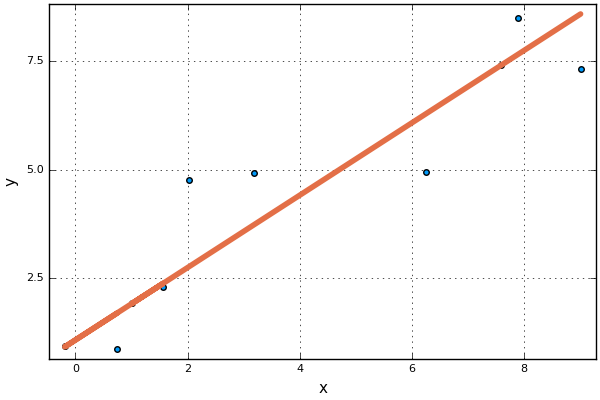

In [14]:
fig = plot(points[:, 1], points[:, 2], t=[:scatter], label="")

y = [getvalue(a)*points[i, 1] + getvalue(b) for i in 1:size(points,1)]
plot!(points[:, 1], y, w=4, xlabel="x", ylabel="y", label="")

fig

Out of curiosity, we can compare our result with a standard Least Square regression. For this, we can use the GLM and DataFrames packages.

In [15]:
Pkg.add("GLM")
Pkg.add("DataFrames")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of GLM
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of DataFrames
INFO: Use `Pkg.update()` to get the latest versions of your packages



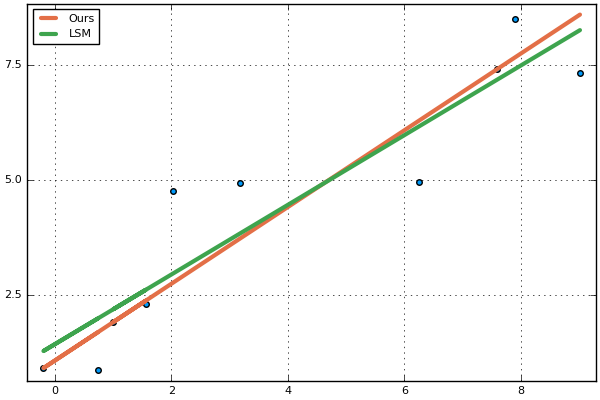

In [16]:
using DataFrames
using GLM
data = DataFrame(X=points[:, 1], Y=points[:, 2])
result = glm(Y ~ X, data, Normal(), IdentityLink())
bLS, aLS = coef(result) 

fig = plot(points[:, 1], points[:, 2], t=[:scatter], label="")

y = [getvalue(a)*points[i, 1] + getvalue(b) for i in 1:size(points,1)]
plot!(points[:, 1], y, label="Ours", w=3)

y = [aLS*points[i, 1] + bLS for i in 1:size(points,1)]
plot!(points[:, 1], y, label="LSM", w=3)

fig

We can see the curves are similar. The least square method have the characteristic of heavily penalize outliers, so points to far from the mean may have a big influence on regression. Note that we have generated the points randomly, you can rerun the experiments to see possible differences in the results.

## A more classical example -- The knapsack problem

Let $i \in I$ be an item with value $v_i$ and volume $c_i$. We want to choose the most valuable subset of items to carry in a knaspack without violating its capacity $C$. Let $x_i \in \{0, 1\}$, $i \in I$ indicate whether item $i$ is put into the knapsack. The following integer program solver our knapsack problem.

$\displaystyle Max\ \sum_{i \in I} v_i x_i$

subject to

$\displaystyle \sum_{i \in I} c_i x_i \leq C,$

$x_i \in \{0, 1\}, i \in I.$

We will implement this program using JuMP. First, we need some input data.

In [17]:
v = [3, 1, 4, 6, 2, 7, 2, 4, 7, 9, 5, 7, 3, 1]  # Value of the items.
c = [2, 5, 3, 8, 9, 6, 4, 8, 2, 2, 1, 4, 2, 3]  # Volume of the items.
n = length(v)  # How many items we have

C = 12  # The capacity of our knapsack.

12

We do the same as before, create our model.

In [18]:
m = Model()

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is default solver

As before, we are not going to creating the variables one by one, we will use the following.

In [19]:
@variable(m, x[i=1:n], Bin)

14-element Array{JuMP.Variable,1}:
 x[1] 
 x[2] 
 x[3] 
 x[4] 
 x[5] 
 x[6] 
 x[7] 
 x[8] 
 x[9] 
 x[10]
 x[11]
 x[12]
 x[13]
 x[14]

Which is a shortcut for adding the variables <i>x[1]</i> to <i>x[|n|]</i> to the model <i>m</i>. To add the objective function we can use the <i> sum </i> function.

In [20]:
@objective(m, Max, sum(v[i]*x[i] for i=1:n))

3 x[1] + x[2] + 4 x[3] + 6 x[4] + 2 x[5] + 7 x[6] + 2 x[7] + 4 x[8] + 7 x[9] + 9 x[10] + 5 x[11] + 7 x[12] + 3 x[13] + x[14]

It can also be used to create constraints.

In [21]:
@constraint(m, sum(x[i]*c[i] for i=1:n) <= C)

m  # Just to print our model.

Maximization problem with:
 * 1 linear constraint
 * 14 variables: 14 binary
Solver is default solver

And then, we can solve our model.

In [22]:
solve(m)

:Optimal

Finally, we can query for the solution.

In [23]:
println("Take \t Don't take")

for i in collect(1:n)
    if getvalue(x[i]) >= 0.99
        println("$i")
    else
        println("\t $i")
    end
end

Take 	 Don't take
	 1
	 2
3
	 4
	 5
	 6
	 7
	 8
9
10
11
12
	 13
	 14


# Solver callbacks

Some solvers enable a setup of user-defined behavior of some of their internal functionalities. This customization is provided as callback functions. Each solver provides its own set of callback function but JuMP can handle few of them. Here, we will see an example of how to use the <i>Lazy Constraints</i> callback that is supported by Gurobi and CPLEX, among others. For the complete list of callbacks JuMP is able to handle see [this link](https://jump.readthedocs.io/en/latest/callbacks.html).

As a motivation, we will use the Traveling Salesman Problem (TSP). The TSP consists of finding the least cost route to visit the nodes in a graph exactly once. Let $c_{ij}$ be the distance between nodes $i$ and $j \in V$. Then, binary variables $x_{ij}, i, j \in V, i \neq j$ indicate whether the route uses the edge $(i, j)$. Thus, the objective function of the problem is:

$$Min \ \sum_{i \in V} \sum_{j \in V} c_{ij} x_{ij},$$

in which $c_{ij}$ are the distance (cost) of going from city $i$ to $j$. Two sets of constraints for the problem are:

$$\sum_{i \in V} x_{ij} = 1, \quad j \in V,$$

$$\sum_{j \in V} x_{ij} = 1, \quad i \in V.$$
These constraints tell that each node is visited exactly once. We also need to prevent solutions with sub-cycles, this can be done with:

$$\sum_{(i, j) \in C} x_{ij} \leq |C| - 1, \quad C \subset V.$$

Note that we have a constraint for each subset of the nodes, which give a number of constraints that is exponential on the number of nodes. Adding all these constraints <i>a priori</i> to our model could make it too big to be solvable. So we are going to use the Lazy Constraints callback.

To implement it, first, we will generate some data and use the Graphs and Gurobi libraries. To install them, we can use:

In [1]:
Pkg.add("Graphs");
Pkg.add("Gurobi");

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Graphs
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Gurobi
INFO: Use `Pkg.update()` to get the latest versions of your packages


Generating the data:

In [2]:
using JuMP
using Gurobi
using Graphs;

nCities = 9  # Number of cities

dist = zeros(nCities, nCities)

citiesPos = Dict{Int, Any}()

# Position of each city
citiesPos[1] = (0, 0)
citiesPos[2] = (10, 0)
citiesPos[3] = (20, 0)

citiesPos[4] = (0, 10)
citiesPos[5] = (10, 10) 
citiesPos[6] = (20, 10)

citiesPos[7] = (0, 20)
citiesPos[8] = (10, 20)
citiesPos[9] = (20, 20)

for (i, posI) in citiesPos
    for (j, posJ) in citiesPos
        dist[i, j] = ((posI[1] - posJ[1])^2 + (posI[2] - posJ[2])^2)^0.5
    end 
end

# Plotting the nodes of the graph:
g = simple_graph(nCities, is_directed=true)
Graphs.plot(g)

Now, we implement the method that will tell whether a solution found by the solver has a sub-cycle. The function must receive a parameter which is the callback handler. Then, we get the solution found and try to find its sub-cycles. We also must use the <i>@lazyconstraint</i> macro to actually add the constraint to the model and re-optimize.

In [3]:
function subtourElimConstraint(cb)

    # Creating a graph:
    g = simple_graph(nCities, is_directed=true)

    for i in 1:nCities, j in 1:nCities
        if i != j
            if getvalue(x[i, j]) > 0.99
                add_edge!(g, i, j)  # Populating the graph.
            end
        end
    end
    
    # Plot it, so we can see the graph:
    Graphs.plot(g)
    
    nodes = vertices(g)
    
    # The idea is to walk through the edges and check how many edges
    # we have to hop to reach the origin. This number will tell us if
    # we are walking on a sub-cycle. If that is the case, we add the 
    # corresponding constraint to the model.
    # We repeat this procedure starting at an unvisited node for finding
    # multiple sub-cycles.
    
    visited = []
    for n in nodes

        if n in visited
            continue
        end

        pivot = n  # Starting node
        out = out_edges(pivot, g)[1]
        outNode = target(out, g)
        append!(visited, [pivot, outNode])

        subtourConstraint = AffExpr()
        subtourConstraint += x[pivot, outNode]
        tourSize = 1

        # While we don't get to the origin, keep hoping...
        while(pivot != outNode)
            out = out_edges(outNode, g)[1]
            newOut = target(out, g)

            subtourConstraint += x[outNode, newOut]
            tourSize += 1
            push!(visited, outNode)
            outNode = newOut
        end

        # If we have traversed the whole graph:
        if tourSize == num_vertices(g)
            return
        else
            # This is the constraint we will add:
            println(subtourConstraint, " <= ", tourSize - 1)
        end
        
        # Using the @lazyconstraint macro
        @lazyconstraint(cb, subtourConstraint <= tourSize - 1)        
    end
    
end

subtourElimConstraint (generic function with 1 method)

We have the method that will add constraints as we need them. Let us check how this works on the model implementation. We begin as usual, defining model, variables, the objective function and constraints...

In [4]:
model = Model(solver=GurobiSolver(TimeLimit=20, Threads=1))

@variable(model, x[i=1:nCities, j=1:nCities; i != j], Bin)

@objective(model, Min, sum(dist[i, j] * x[i, j] for i in 1:nCities, j in 1:nCities if i != j));

for i in 1:nCities
    @constraint(model, sum(x[i, j] for j in 1:nCities if i != j) == 1)
end 
        
for j in 1:nCities
    @constraint(model, sum(x[i, j] for i in 1:nCities if i != j) == 1)
end

Then, before solving, we need to tell that we will be using the callback and which is the function with the customized behavior.

In [5]:
addlazycallback(model, subtourElimConstraint)

# And the, solving:
solve(model)

Optimize a model with 18 rows, 72 columns and 144 nonzeros
Variable types: 0 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
x[1,9] + x[9,2] + x[2,4] + x[4,6] + x[6,7] + x[7,3] + x[3,1] <= 6
x[5,8] + x[8,5] <= 1
Presolve time: 0.00s
Presolved: 18 rows, 72 columns, 144 nonzeros
Variable types: 0 continuous, 72 integer (72 binary)
x[1,2] + x[2,1] <= 1
x[3,5] + x[5,6] + x[6,3] <= 2
x[4,7] + x[7,4] <= 1
x[8,9] + x[9,8] <= 1
x[1,9] + x[9,1] <= 1
x[2,8] + x[8,2] <= 1
x[3,7] + x[7,3] <= 1
x[4,5] + x[5,6] + x[6,4] <= 2

Root relaxation: objective 9.414214e+01, 17 iterations, 0.00 seconds
x[1,5] + x[5,4] + x[4,1] <= 2
x[2,3] + x[3,2] <= 1
x[6,9] + x[9,6] <= 1
x[7,8] + x[8,7] <= 1

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0         

:Optimal

To check the final solution, we can proceed as follows.

In [6]:
# Creating a graph:
g = simple_graph(nCities, is_directed=true)

for i in 1:nCities, j in 1:nCities
    if i != j
        if getvalue(x[i, j]) > 0.99
            add_edge!(g, i, j)  # Populating the graph.
        end
    end
end

# Plot it, so we can see the graph:
Graphs.plot(g)

Note that the graph library we are using do not plot the nodes in their exact positions. You can draw them to check if it makes sense.

In this Notebook, we have explored the basics of JuMP regarding mixed integer linear programming and the lazy constraint callback. For a more detailed exposition the reader is referred to [JuMP documentation](https://jump.readthedocs.io/en/latest/).

Hope you had fun! (=